In [221]:
#!pip install pyshp
# !pip install geopy

In [222]:
import os
from dotenv import load_dotenv
load_dotenv()
user_agent = os.getenv('user_agent')
print(user_agent)

harsh.swizard@gmail.com


In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from  shapely.geometry import Point, Polygon
import geopandas as gpd
import seaborn as sns
import geopy
# %matplotlib inline

In [224]:
# load the train data.
wnv_raw_train = pd.read_csv("../data/train.csv")

# load the weather data.
wnv_raw_weather = pd.read_csv("../data/weather.csv")

In [225]:
# explore train data.
print ("shape of train dataset (row, col) =",wnv_raw_train.shape)
wnv_raw_train.info()

shape of train dataset (row, col) = (10506, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


There does not seem  to be any missing value. Our target variable = WnvPresent

In [226]:
wnv_raw_train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


## Explore the colums.

In [227]:
wnv_raw_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [228]:
# convert the data type of date column from object to date.
wnv_raw_train["Date"] = pd.to_datetime(wnv_raw_train["Date"])
# add new column year-mm.
# we could use it to compare yearly, monthly change across the dataset.
wnv_raw_train["year-mm"] = pd.DatetimeIndex(wnv_raw_train["Date"]).to_period("M")
wnv_raw_train["year"] = pd.DatetimeIndex(wnv_raw_train["Date"]).year
wnv_raw_train["month"] = pd.DatetimeIndex(wnv_raw_train["Date"]).month

# add a column - zip codes
wnv_raw_train["zip_code"] =wnv_raw_train.Address.str.extract(r'(\d{5}\-?\d{0,4})')

# get the column names.
obj_col_nms = wnv_raw_train.select_dtypes(include="object").columns
not_obj_col_nms = wnv_raw_train.select_dtypes(exclude=["object", "datetime64"]).columns

print (obj_col_nms)
print (not_obj_col_nms)


Index(['Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet',
       'zip_code'],
      dtype='object')
Index(['Block', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'year-mm', 'year', 'month'],
      dtype='object')


In [229]:
col_nms = ['WnvPresent', 'Species', 'Trap', 'NumMosquitos' ]
print (f"value count for WnvPresent =")
print (wnv_raw_train["WnvPresent"].value_counts())


value count for WnvPresent =
0    9955
1     551
Name: WnvPresent, dtype: int64


Maximum # of data in the dataset does not contain virus. This is an imbalance. Can we balance it ?

In [230]:
print (f"value count for Species =")
print (wnv_raw_train["Species"].value_counts())

value count for Species =
CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64


In [231]:
# Top 3 and map other species to "Others"
other_species = {'CULEX TERRITANS':"CLUEX-OTHERS",'CULEX SALINARIUS':"CLUEX-OTHERS",'CULEX TARSALIS':"CLUEX-OTHERS",'CULEX ERRATICUS':"CLUEX-OTHERS"}
wnv_raw_train["Species"]= wnv_raw_train["Species"].replace(other_species)

In [232]:
wnv_raw_train.groupby(["Block"], sort=True)[col_nms].agg({"Species":"nunique", "Trap":"count", "NumMosquitos":"sum", "WnvPresent":"sum"})\
    .nlargest(columns=["NumMosquitos", "WnvPresent"],n=30).T

Block,10,12,11,70,22,42,41,37,52,24,...,89,51,65,67,46,33,36,71,25,38
Species,4,4,4,4,4,4,4,4,4,4,...,4,4,3,4,4,4,4,4,4,4
Trap,1722,605,736,295,500,300,185,330,277,160,...,157,132,117,116,122,179,133,133,218,68
NumMosquitos,31852,21789,8669,4637,4254,3845,3710,3597,3327,3315,...,1509,1496,1426,1356,1346,1317,1311,1093,1047,924
WnvPresent,111,41,26,16,29,16,18,7,16,11,...,4,11,10,6,14,7,11,8,2,3


Block 10 has the highest number of mosquitos count along with the virus.

<AxesSubplot:>

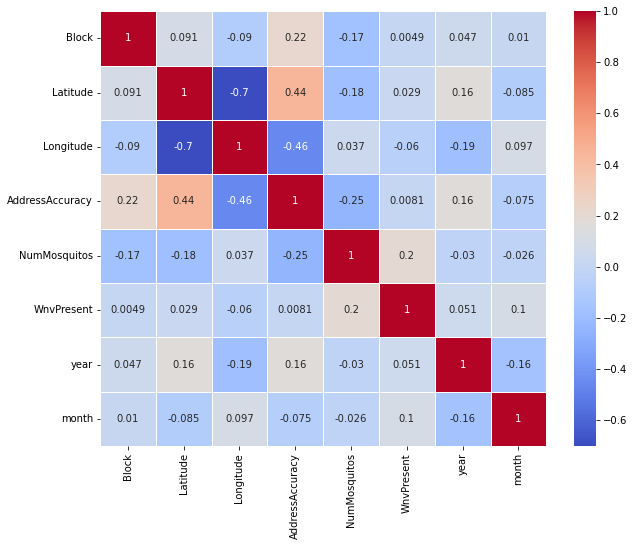

In [233]:
plt.figure(figsize=(10,8))
sns.heatmap(wnv_raw_train.corr(), linewidths=1, annot=True, cmap="coolwarm")

<AxesSubplot:>

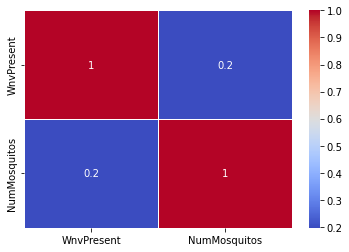

In [234]:
sns.heatmap(wnv_raw_train[col_nms].corr(), linewidths=1, annot=True, cmap="coolwarm")

<AxesSubplot:>

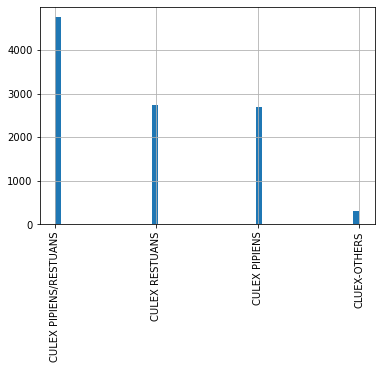

In [235]:
# Species vs blocks.
wnv_raw_train.Species.hist(bins = 50, xrot=90)

In [236]:
years = sorted(wnv_raw_train["year"].unique())
print (years)

[2007, 2009, 2011, 2013]


In [237]:
wnv_raw_train.isnull().any()

Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude                  False
Longitude                 False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
year-mm                   False
year                      False
month                     False
zip_code                   True
dtype: bool

Zip Code have null values. Let's explore it.

In [238]:
wnv_raw_train[wnv_raw_train["zip_code"].isnull()].head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year-mm,year,month,zip_code
58,2007-06-05,"South Vincennes Avenue, Chicago, IL, USA",CULEX RESTUANS,10,S VINCENNES,T089,"1000 S VINCENNES, Chicago, IL",41.723195,-87.649970,5,1,0,2007-06,2007,6,NaN
69,2007-06-05,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,3,0,2007-06,2007,6,NaN
127,2007-06-26,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,2007-06,2007,6,NaN
172,2007-06-29,"South Vincennes Avenue, Chicago, IL, USA",CULEX RESTUANS,10,S VINCENNES,T089,"1000 S VINCENNES, Chicago, IL",41.723195,-87.649970,5,2,0,2007-06,2007,6,NaN
179,2007-06-29,"Chicago, IL, USA",CULEX RESTUANS,43,N ASHLAND AVE OVERPASS,T145,"4300 N ASHLAND AVE OVERPASS, Chicago, IL",41.878114,-87.629798,3,1,0,2007-06,2007,6,NaN


In [239]:
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']

In [240]:
geolocator = geopy.Nominatim(user_agent='user_agent')

In [241]:
%%time
zipcodes = wnv_raw_train[wnv_raw_train["zip_code"].isnull()].apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')

CPU times: user 2.96 s, sys: 438 ms, total: 3.4 s
Wall time: 12min 34s
CPU times: user 3.02 s, sys: 446 ms, total: 3.47 s
Wall time: 12min 33s


In [242]:
zipcodes.columns = "zip_code"

In [243]:
wnv_raw_train=wnv_raw_train.merge(zipcodes.rename("zipcodes"), how="left", left_index=True , right_index=True)

In [244]:
wnv_raw_train["zip_code"].fillna(wnv_raw_train["zipcodes"], inplace=True)

Now we can drop the derived zipcodes column.

In [245]:
wnv_raw_train.drop(columns=["zipcodes"], inplace=True)

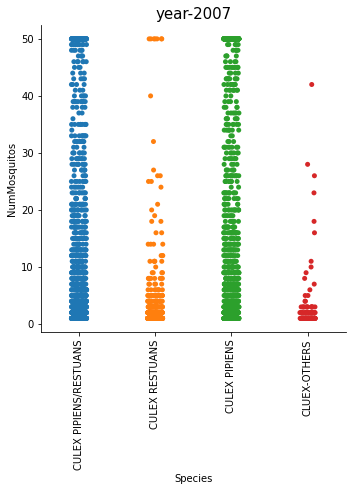

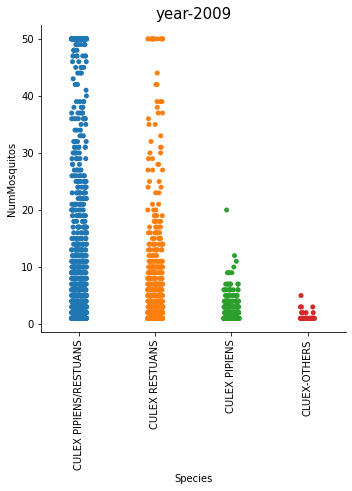

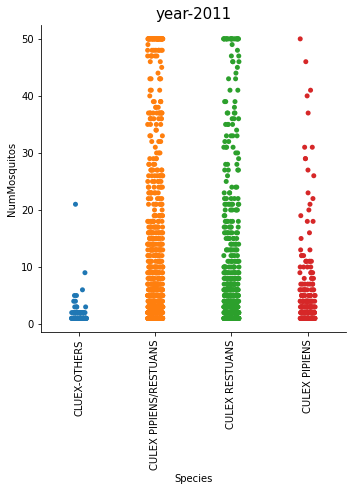

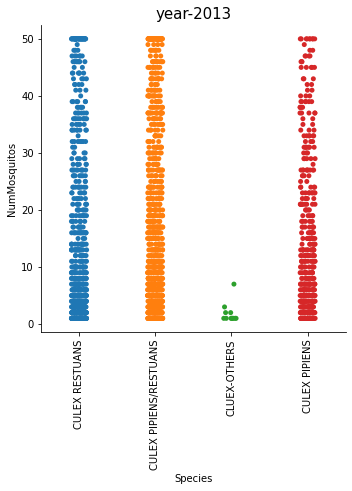

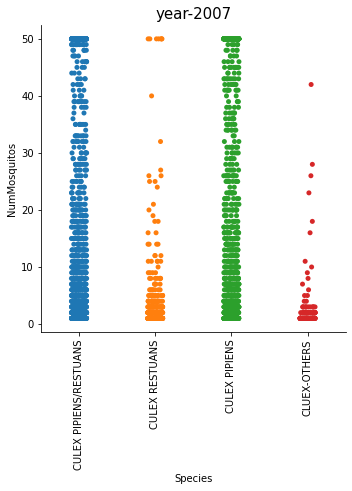

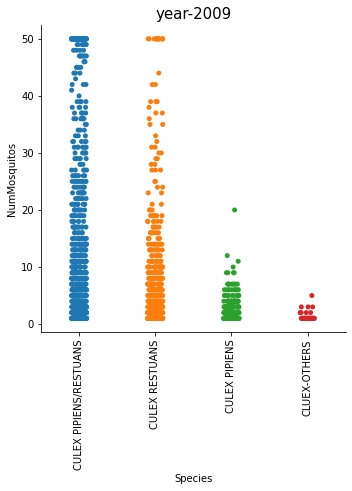

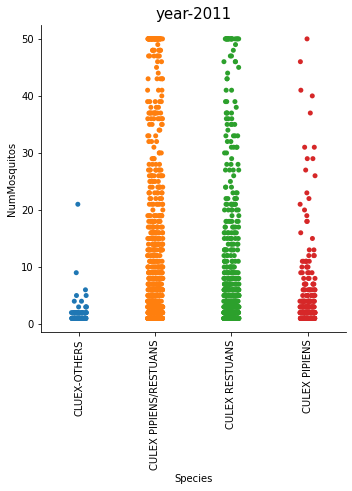

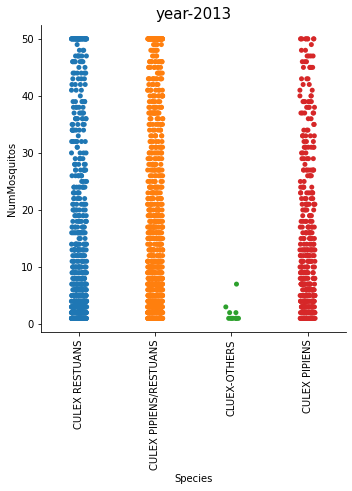

In [246]:
for yr in years:
    chart = sns.catplot(x="Species", y="NumMosquitos",
                    #  height=2.5, aspect=4,
                    data=wnv_raw_train[wnv_raw_train["Date"].dt.year == yr] )
    plt.xticks(rotation=90 )
    plt.title(f"year-{yr}", fontsize=15)

In [247]:
#shape path:
shp_path = "../maps/Boundaries_ZIP Codes/geo_export_cdb0292c-9556-4a83-aafd-c9525a4462e3.shp"

In [248]:
# Visualize the cities.
street_map = gpd.read_file(shp_path)

In [249]:

# designate coordinate system
crs = {"init":"epsg:3857"}

# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(wnv_raw_train["Longitude"], wnv_raw_train["Latitude"])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(wnv_raw_train, crs = crs, geometry = geometry)

geo_df.head()

/Users/harshchauhan/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year-mm,year,month,zip_code,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007-05,2007,5,60634,POINT (-87.801 41.955)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007-05,2007,5,60634,POINT (-87.801 41.955)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007-05,2007,5,60646,POINT (-87.769 41.995)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007-05,2007,5,60656,POINT (-87.825 41.974)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007-05,2007,5,60656,POINT (-87.825 41.974)


/Users/harshchauhan/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,year-mm,year,month,zip_code,geometry
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007-05,2007,5,60634,POINT (-87.801 41.955)
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007-05,2007,5,60634,POINT (-87.801 41.955)
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007-05,2007,5,60646,POINT (-87.769 41.995)
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007-05,2007,5,60656,POINT (-87.825 41.974)
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007-05,2007,5,60656,POINT (-87.825 41.974)


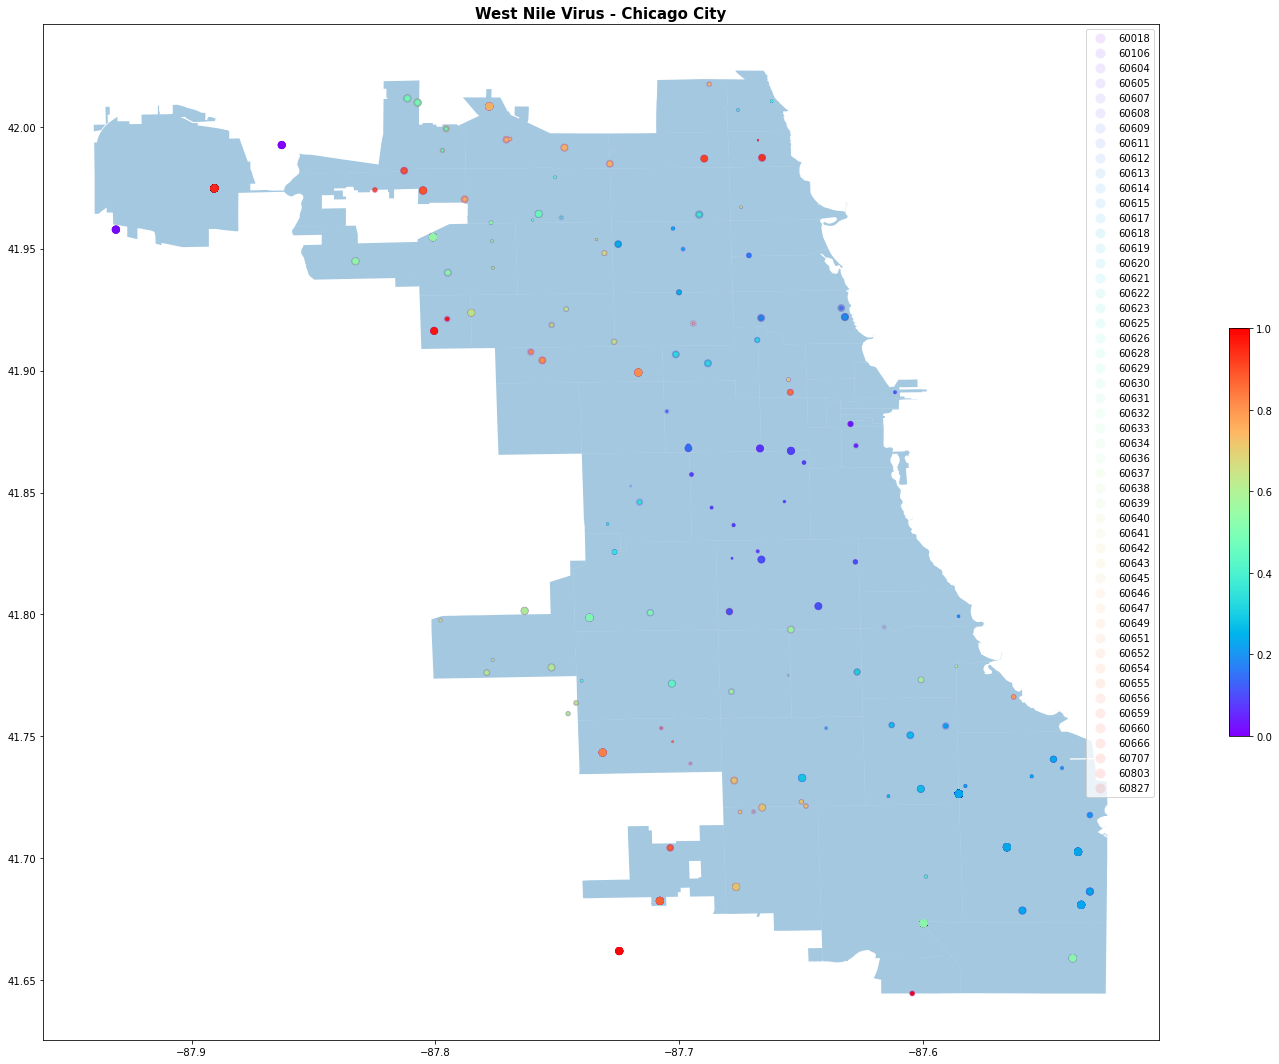

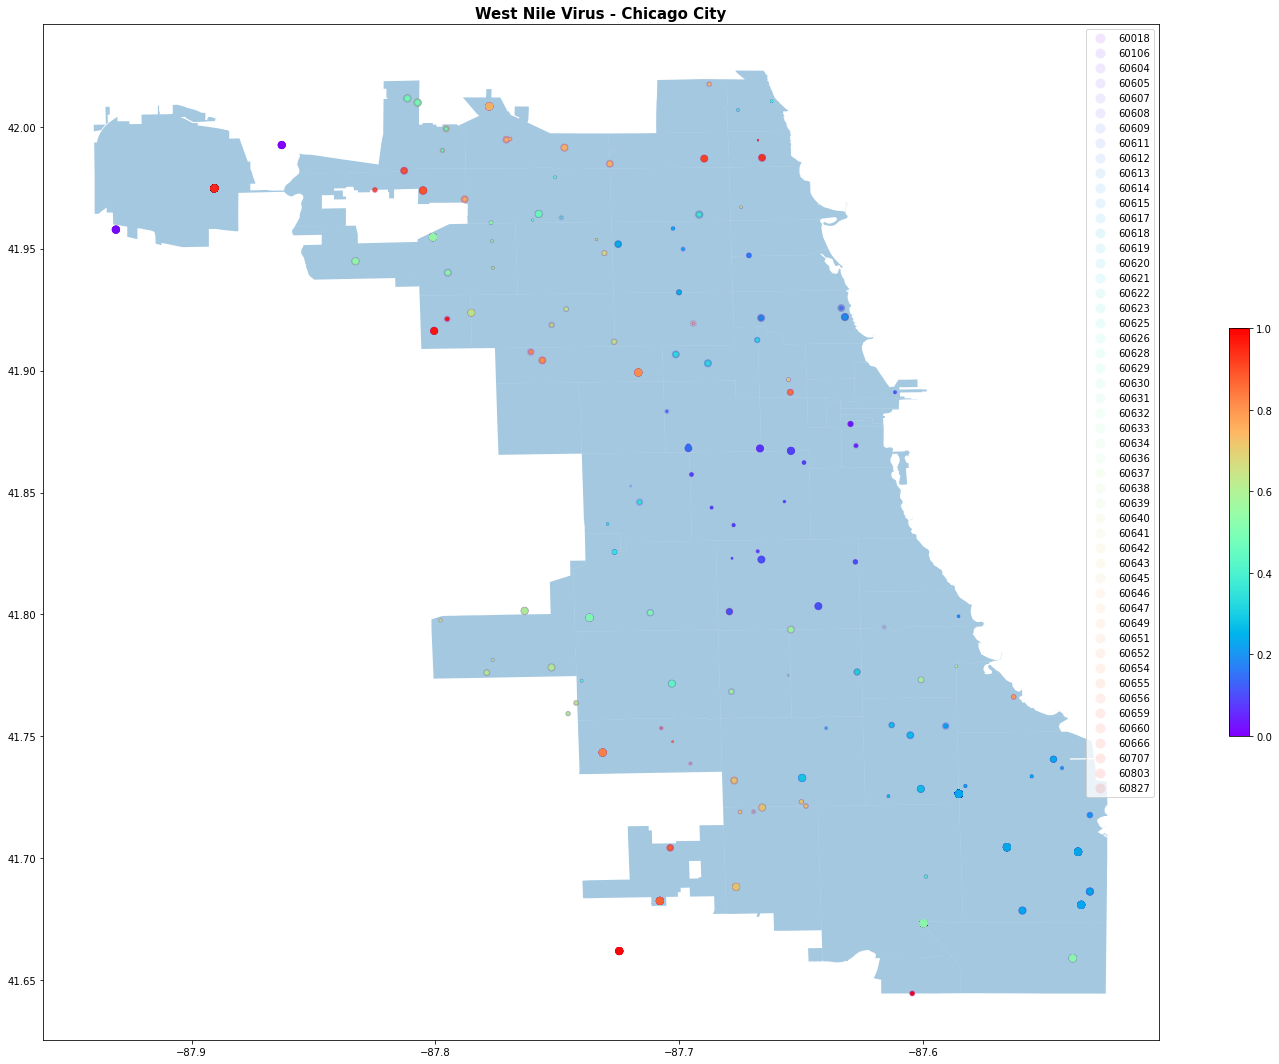

In [250]:
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(25,25))
# add .shp mapfile to axes
street_map.plot(ax=ax, alpha=0.4)
# add geodataframe to axes
geo_df.plot(column="WnvPresent",ax=ax,alpha=0.1, legend=True,markersize="NumMosquitos", cmap="rainbow", legend_kwds={'shrink': 0.3})

geo_df.plot(column="zip_code",ax=ax,alpha=0.1, markersize="NumMosquitos", cmap="rainbow", legend = True)
# add title to graph
plt.title("West Nile Virus - Chicago City", fontsize=15,fontweight="bold")

# show map
plt.show()

In [251]:
# read shape file
shp_data = shp.Reader(shp_path)
len(shp_data.shapes())

61

61

In [252]:
shp_data.records()[0]

Record #0: [33.0, 106052287.488, 42720.0444058, '60647']

Record #0: [33.0, 106052287.488, 42720.0444058, '60647']

In [253]:
# convert the shape file to dataframe
def read_shapefile(sf):
    #fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    df = df.assign(coords=shps)
    return df

In [254]:
df = read_shapefile(shp_data)
df.head()

,objectid,shape_area,shape_len,zip,coords
0,33.0,1.060523e+08,42720.044406,60647,"[(-87.67762151065281, 41.917757801062976), (-8..."
1,34.0,1.274761e+08,48103.782721,60639,"[(-87.72683253163021, 41.9226462671259), (-87...."
2,35.0,4.506904e+07,27288.609612,60707,"[(-87.78500237831095, 41.909147854716764), (-8..."
3,36.0,7.085383e+07,42527.989679,60622,"[(-87.6670686895295, 41.888851884969924), (-87..."
4,37.0,9.903962e+07,47970.140153,60651,"[(-87.70655631674127, 41.89555340699404), (-87..."


,objectid,shape_area,shape_len,zip,coords
0,33.0,1.060523e+08,42720.044406,60647,"[(-87.67762151065281, 41.917757801062976), (-8..."
1,34.0,1.274761e+08,48103.782721,60639,"[(-87.72683253163021, 41.9226462671259), (-87...."
2,35.0,4.506904e+07,27288.609612,60707,"[(-87.78500237831095, 41.909147854716764), (-8..."
3,36.0,7.085383e+07,42527.989679,60622,"[(-87.6670686895295, 41.888851884969924), (-87..."
4,37.0,9.903962e+07,47970.140153,60651,"[(-87.70655631674127, 41.89555340699404), (-87..."


In [255]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (25,15)):
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')

        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1

    if (x_lim != None) & (y_lim != None):
        plt.xlim(x_lim)
        plt.ylim(y_lim)

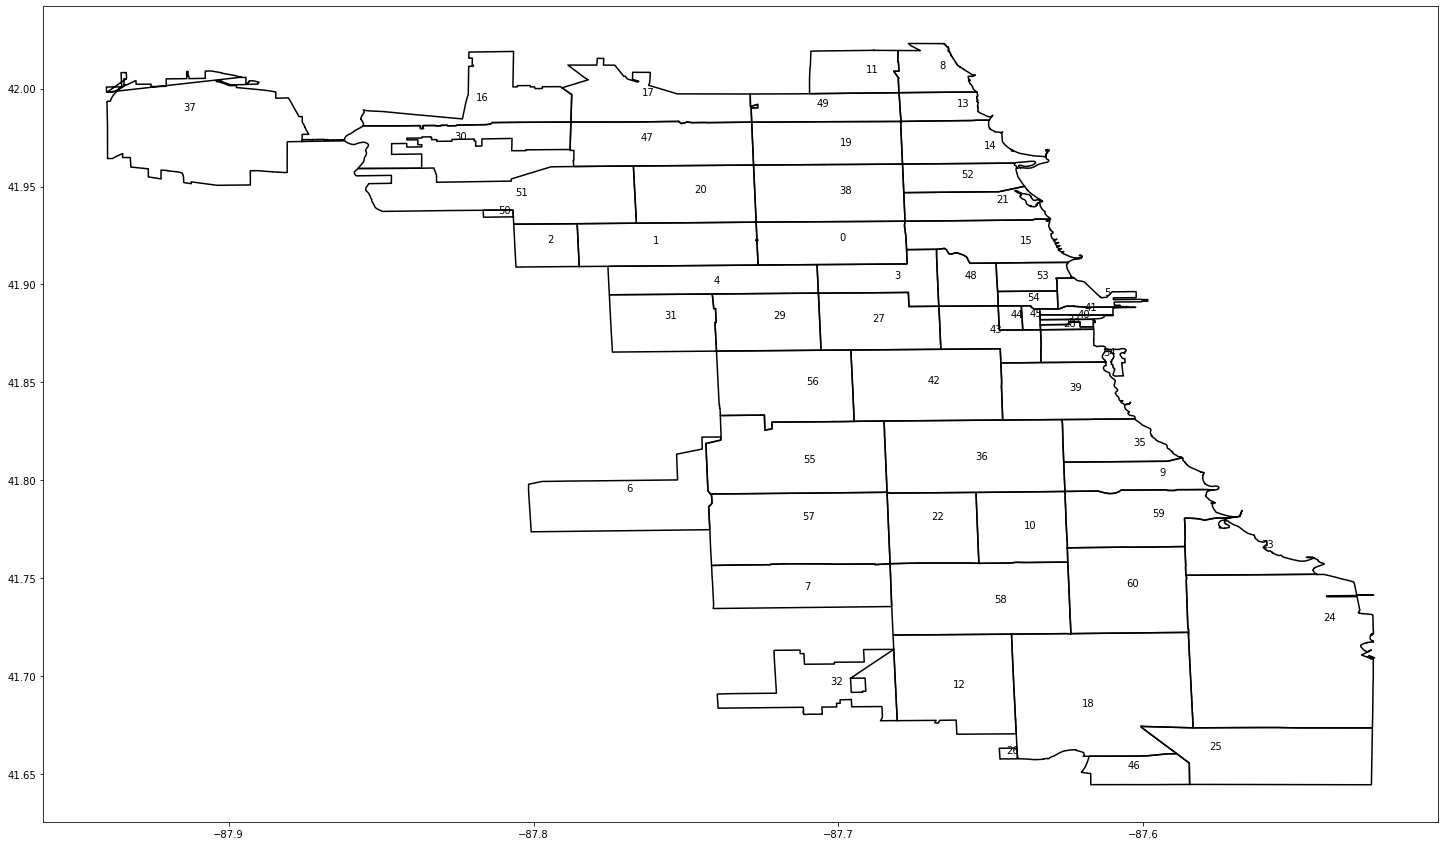

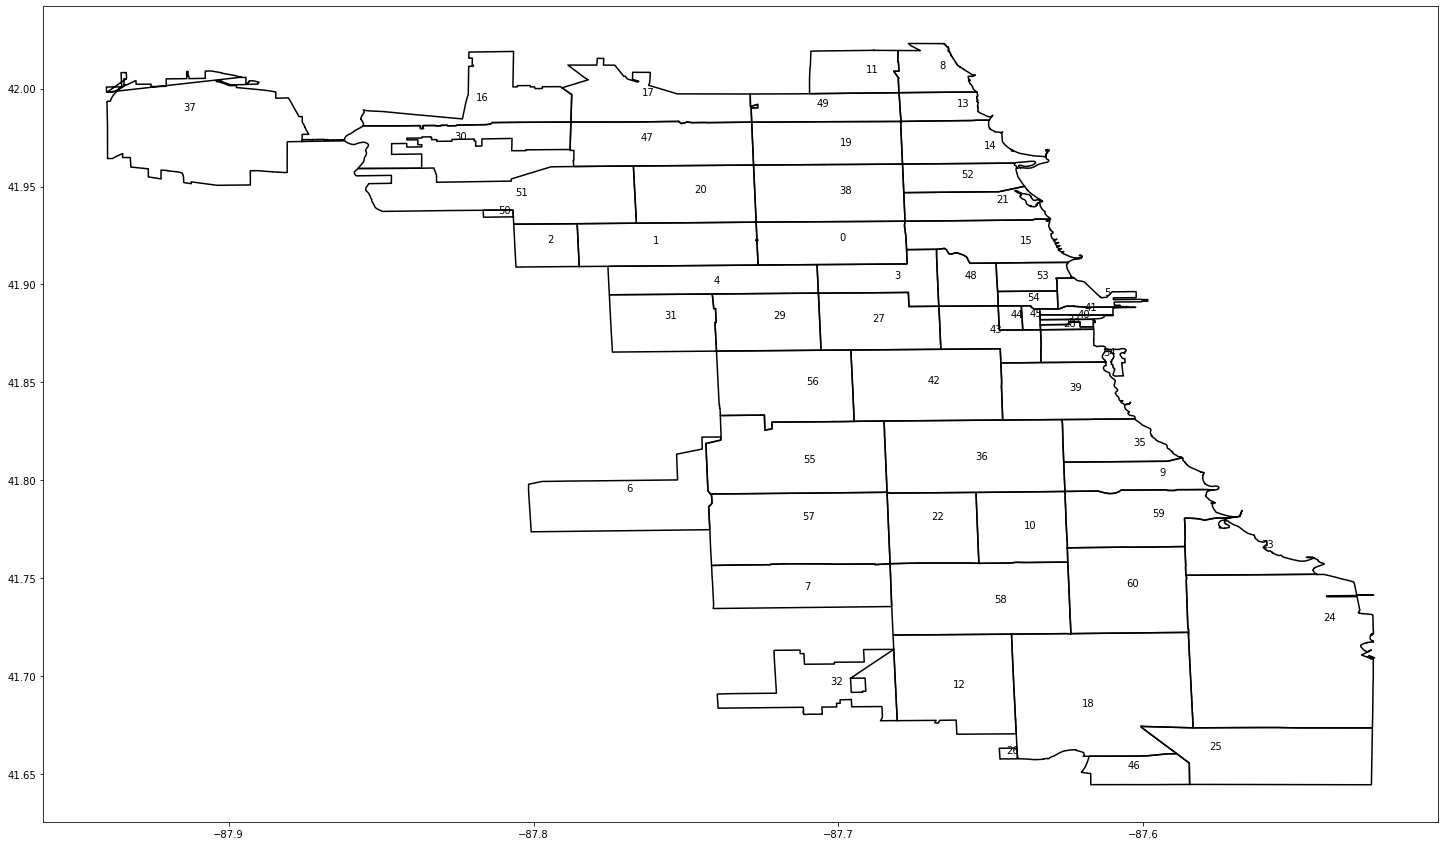

In [256]:
plot_map(shp_data)

### Analyze Weather dataset.

In [257]:
wnv_raw_weather.shape

(2944, 22)

(2944, 22)

In [258]:
wnv_raw_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [259]:
wnv_raw_weather.Station.unique()

array([1, 2])

array([1, 2])

In [260]:
wnv_raw_weather.StnPressure.unique()

array(['29.10', '29.18', '29.38', '29.44', '29.39', '29.46', '29.31',
       '29.36', '29.40', '29.57', '29.62', '29.29', '29.21', '29.28',
       '29.20', '29.26', '29.33', '29.49', '29.54', '29.55', '29.23',
       '29.13', '29.19', '29.53', '29.60', '29.34', '29.41', '29.47',
       '29.51', '29.42', '29.43', '29.25', '29.03', '28.82', '28.87',
       '28.88', '29.16', '29.07', '28.84', '28.91', '29.24', 'M', '29.30',
       '29.12', '29.45', '29.56', '29.32', '29.05', '29.11', '29.06',
       '29.22', '29.08', '29.14', '29.37', '29.35', '29.15', '29.17',
       '29.48', '29.52', '29.27', '29.50', '28.59', '28.67', '28.75',
       '29.02', '29.79', '29.86', '29.63', '29.70', '28.95', '29.01',
       '28.79', '28.85', '28.97', '28.89', '28.94', '28.93', '28.98',
       '28.96', '29.00', '29.66', '29.09', '28.90', '29.04', '29.59',
       '29.65', '29.58', '29.61', '29.64', '29.71', '29.67', '28.80',
       '28.73', '29.68', '28.74', '28.55', '28.63', '28.92', '28.99',
       '28.81',

array(['29.10', '29.18', '29.38', '29.44', '29.39', '29.46', '29.31',
       '29.36', '29.40', '29.57', '29.62', '29.29', '29.21', '29.28',
       '29.20', '29.26', '29.33', '29.49', '29.54', '29.55', '29.23',
       '29.13', '29.19', '29.53', '29.60', '29.34', '29.41', '29.47',
       '29.51', '29.42', '29.43', '29.25', '29.03', '28.82', '28.87',
       '28.88', '29.16', '29.07', '28.84', '28.91', '29.24', 'M', '29.30',
       '29.12', '29.45', '29.56', '29.32', '29.05', '29.11', '29.06',
       '29.22', '29.08', '29.14', '29.37', '29.35', '29.15', '29.17',
       '29.48', '29.52', '29.27', '29.50', '28.59', '28.67', '28.75',
       '29.02', '29.79', '29.86', '29.63', '29.70', '28.95', '29.01',
       '28.79', '28.85', '28.97', '28.89', '28.94', '28.93', '28.98',
       '28.96', '29.00', '29.66', '29.09', '28.90', '29.04', '29.59',
       '29.65', '29.58', '29.61', '29.64', '29.71', '29.67', '28.80',
       '28.73', '29.68', '28.74', '28.55', '28.63', '28.92', '28.99',
       '28.81',

TAvg has a Missing Value - M. We can impute the average value from Tmax and Tmin.

Depart, WetBulb,Heat,Cool, Depth, Water1 (all missing), SnowFall, PrecipTotal,  also has missing Value - M.
Sunrise, Sunset - missing value  "-"

In [261]:
# strip the leading and trailing spaces.
for col in wnv_raw_weather.select_dtypes(include="object"):
    if wnv_raw_weather[wnv_raw_weather[col].str.strip()== 'T'].any().sum() > 0:
        print (col, ':', wnv_raw_weather[wnv_raw_weather[col].str.strip()== 'T'].any().sum())
        wnv_raw_weather[col] = wnv_raw_weather[col].str.strip()
        print (col, ':', wnv_raw_weather[wnv_raw_weather[col] == 'T'].any().sum())

SnowFall : 22
SnowFall : 22
PrecipTotal : 22
PrecipTotal : 22
SnowFall : 22
SnowFall : 22
PrecipTotal : 22
PrecipTotal : 22


In [262]:
# replace the missing values with NAN
wnv_raw_weather.replace({"M":np.nan, "-":np.nan, "T": np.nan}, inplace=True)


In [263]:
# Water1 column is totally blank. We can drop this column.
wnv_raw_weather.drop(columns=["Water1"], axis=1, inplace=True)


## Observations and next steps:

1. Water1 column is totally blank. We can drop this column.
2. Need to replace the missing value's symbolic representation to NAN.
3. Convert the data type of the columns to Numeric.
4. Impute the missing Value.


In [264]:
# check if there are still columns with "M"
wnv_raw_weather["StnPressure"].isnull().any().sum()

1

1

In [265]:
total_rows = wnv_raw_weather.shape[0]
column_list_null_value = wnv_raw_weather.columns[wnv_raw_weather.isnull().any()].to_list()
print (column_list_null_value)

['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']


In [266]:
# impute missing value for Tavg
temp =  wnv_raw_weather[["Tmin","Tmax", "Tavg"]]
temp_tavg_computed = temp.T.fillna(np.ceil(temp.mean(axis=1))).T.copy()
temp_tavg_computed.head(10)
wnv_raw_weather["Tavg"] = temp_tavg_computed["Tavg"]

# check if the original dataset has missing values
print ("Missing values in Tavg = ", wnv_raw_weather["Tavg"].isnull().any().sum())

/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/213198099.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_tavg_computed = temp.T.fillna(np.ceil(temp.mean(axis=1))).T.copy()


Missing values in Tavg =  0


/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/213198099.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_tavg_computed = temp.T.fillna(np.ceil(temp.mean(axis=1))).T.copy()


Missing values in Tavg =  0


In [267]:
wnv_raw_weather.head()
print (wnv_raw_weather.columns)

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')
Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')


In [268]:
wnv_raw_weather.groupby(["Station"])[["Depart", "DewPoint", "WetBulb"]].count()

,Depart,DewPoint,WetBulb
Station,,,
1,1472,1472,1469
2,0,1472,1471


,Depart,DewPoint,WetBulb
Station,,,
1,1472,1472,1469
2,0,1472,1471


In [269]:
wnv_raw_weather.fillna(method = "ffill", inplace=True)
# check again.
col_list = [col for col in wnv_raw_weather.columns if col != "Station"]
wnv_raw_weather.groupby(["Station"])[col_list].count()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Station,,,,,,,,,,,,,,,,,,,,
1,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472
2,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472


,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Station,,,,,,,,,,,,,,,,,,,,
1,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472
2,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472,1472


Departure from Normal is blank for station 2. we can ignore this column.

In [270]:
wnv_raw_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,Sunset,CodeSum,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,1849,,0,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,14,51,57,0,3,...,1849,,0,0.0,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,1850,BR,0,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,-3,42,47,13,0,...,1850,BR HZ,0,0.0,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,1851,,0,0.0,0.00,29.39,30.12,11.7,7,11.9


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,Sunset,CodeSum,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,1849,,0,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,14,51,57,0,3,...,1849,,0,0.0,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,1850,BR,0,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,-3,42,47,13,0,...,1850,BR HZ,0,0.0,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,1851,,0,0.0,0.00,29.39,30.12,11.7,7,11.9


In [271]:
weather = wnv_raw_weather.astype({ "Tavg":"int64", "WetBulb":"int64"
                           , "Heat":"int64", "Cool":"int64", "ResultDir":"int64", "Depth":"int64"
                           ,  "StnPressure":"float64"
                           , "PrecipTotal":"float64","SnowFall":"float64"
                           , "SeaLevel":"float64"
                           , "ResultSpeed":"float64"
                           , "AvgSpeed":"float64"
                           , "Date":"datetime64[ns]"
                        }, copy=True)

We can drop sunrise and sunset from our weather dataset.
Also, we need to add the location specific information to <b>"weather" and "train"</b> dataset.
Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [272]:
weather["Latitude"] = np.nan
weather["Longitude"] = np.nan
weather["Latitude"][weather["Station"]==1] = 41.995
weather["Latitude"][weather["Station"]==2] = 41.786
weather["Longitude"][weather["Station"]==1] = -87.933
weather["Longitude"][weather["Station"]==2] = -87.752
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   int64         
 8   Heat         2944 non-null   int64         
 9   Cool         2944 non-null   int64         
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   int64         
 14  SnowFall     2944 non-null   float64       
 15  PrecipTotal  2944 non-null   float64       
 16  StnPre

/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/891305719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["Latitude"][weather["Station"]==1] = 41.995
/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/891305719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["Latitude"][weather["Station"]==2] = 41.786
/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/891305719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   int64         
 8   Heat         2944 non-null   int64         
 9   Cool         2944 non-null   int64         
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   int64         
 14  SnowFall     2944 non-null   float64       
 15  PrecipTotal  2944 non-null   float64       
 16  StnPre

/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/891305719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["Latitude"][weather["Station"]==1] = 41.995
/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/891305719.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["Latitude"][weather["Station"]==2] = 41.786
/var/folders/j9/lt4t16ks2x53m13gthmz57c40000gn/T/ipykernel_62739/891305719.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [273]:
train = wnv_raw_train.copy(deep=True)

In [274]:
train["Stn1-Lat"] = 41.995
train["Stn2-Lat"] = 41.786
train["Stn1-Long"] = -87.933
train["Stn2-Long"] = -87.752
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  year-mm                 10506 non-null  period

In [275]:
print ('Duplicates in train : ', train.duplicated().any().sum())
print ('Duplicates in weather : ', weather.duplicated().any().sum())

Duplicates in train :  1
Duplicates in weather :  0
Duplicates in train :  1
Duplicates in weather :  0


In [276]:
stn1_coord = pd.Series(zip(train["Stn1-Lat"], train["Stn1-Long"])).unique()
stn2_coord = pd.Series(zip(train["Stn2-Lat"], train["Stn2-Long"])).unique()

print (stn1_coord, stn2_coord)

[(41.995, -87.933)] [(41.786, -87.752)]
[(41.995, -87.933)] [(41.786, -87.752)]


In [277]:
def get_distance_stn(row, stn_coord) :
    loc1 = (row["Latitude"], row["Longitude"])
    loc2 = stn_coord
    return round(distance.distance(loc1, loc2).miles, 2)

In [278]:
def get_closer_stn(row):
    if row["distance_frm_stn1"] <= row["distance_frm_stn2"]:
        return 1
    else:
        return 2

In [279]:
train["distance_frm_stn1"] = train.apply(get_distance_stn, args=(stn1_coord,) ,axis=1)
train["distance_frm_stn2"] = train.apply(get_distance_stn, args=(stn2_coord,) ,axis=1)
train["closest_station"] = train[["distance_frm_stn1", "distance_frm_stn2"]].apply(get_closer_stn, axis = 1)

In [280]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,month,zip_code,geometry,Stn1-Lat,Stn2-Lat,Stn1-Long,Stn2-Long,distance_frm_stn1,distance_frm_stn2,closest_station
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,5,60634,POINT (-87.801 41.955),41.995,41.786,-87.933,-87.752,7.35,11.91,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,5,60634,POINT (-87.801 41.955),41.995,41.786,-87.933,-87.752,7.35,11.91,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,5,60646,POINT (-87.769 41.995),41.995,41.786,-87.933,-87.752,8.43,14.45,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,5,60656,POINT (-87.825 41.974),41.995,41.786,-87.933,-87.752,5.75,13.51,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,5,60656,POINT (-87.825 41.974),41.995,41.786,-87.933,-87.752,5.75,13.51,1


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,month,zip_code,geometry,Stn1-Lat,Stn2-Lat,Stn1-Long,Stn2-Long,distance_frm_stn1,distance_frm_stn2,closest_station
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,5,60634,POINT (-87.801 41.955),41.995,41.786,-87.933,-87.752,7.35,11.91,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,5,60634,POINT (-87.801 41.955),41.995,41.786,-87.933,-87.752,7.35,11.91,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,5,60646,POINT (-87.769 41.995),41.995,41.786,-87.933,-87.752,8.43,14.45,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,5,60656,POINT (-87.825 41.974),41.995,41.786,-87.933,-87.752,5.75,13.51,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,5,60656,POINT (-87.825 41.974),41.995,41.786,-87.933,-87.752,5.75,13.51,1


In [281]:
train.groupby("closest_station")["Date"].count()

closest_station
1    3298
2    7208
Name: Date, dtype: int64

closest_station
1    3298
2    7208
Name: Date, dtype: int64

In [282]:
weather.groupby("Station")["Date"].count()

Station
1    1472
2    1472
Name: Date, dtype: int64

Station
1    1472
2    1472
Name: Date, dtype: int64

In [283]:
train_weather = train.merge(right=weather, how="inner", left_on=["closest_station", "Date"], right_on=["Station", "Date"], copy=True)
train_weather.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Latitude_y,Longitude_y
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude_x,Longitude_x,AddressAccuracy,...,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Latitude_y,Longitude_y
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,0.0,0.0,29.39,30.11,5.8,18,6.5,41.995,-87.933


In [284]:
train_weather.shape

(10506, 46)

(10506, 46)

In [285]:
train_weather.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,10506.0,35.687797,2.433947e+01,10.000000,12.000000,33.000000,52.000000,98.000000
Latitude_x,10506.0,41.841139,1.127415e-01,41.644612,41.732984,41.846283,41.954690,42.017430
Longitude_x,10506.0,-87.699908,9.651417e-02,-87.930995,-87.760070,-87.694991,-87.627796,-87.531635
AddressAccuracy,10506.0,7.819532,1.452921e+00,3.000000,8.000000,8.000000,9.000000,9.000000
NumMosquitos,10506.0,12.853512,1.613382e+01,1.000000,2.000000,5.000000,17.000000,50.000000
WnvPresent,10506.0,0.052446,2.229357e-01,0.000000,0.000000,0.000000,0.000000,1.000000
year,10506.0,2009.576242,2.354645e+00,2007.000000,2007.000000,2009.000000,2011.000000,2013.000000
month,10506.0,7.692557,1.067675e+00,5.000000,7.000000,8.000000,8.000000,10.000000
Stn1-Lat,10506.0,41.995000,3.787373e-12,41.995000,41.995000,41.995000,41.995000,41.995000
Stn2-Lat,10506.0,41.786000,5.592237e-12,41.786000,41.786000,41.786000,41.786000,41.786000


,count,mean,std,min,25%,50%,75%,max
Block,10506.0,35.687797,2.433947e+01,10.000000,12.000000,33.000000,52.000000,98.000000
Latitude_x,10506.0,41.841139,1.127415e-01,41.644612,41.732984,41.846283,41.954690,42.017430
Longitude_x,10506.0,-87.699908,9.651417e-02,-87.930995,-87.760070,-87.694991,-87.627796,-87.531635
AddressAccuracy,10506.0,7.819532,1.452921e+00,3.000000,8.000000,8.000000,9.000000,9.000000
NumMosquitos,10506.0,12.853512,1.613382e+01,1.000000,2.000000,5.000000,17.000000,50.000000
WnvPresent,10506.0,0.052446,2.229357e-01,0.000000,0.000000,0.000000,0.000000,1.000000
year,10506.0,2009.576242,2.354645e+00,2007.000000,2007.000000,2009.000000,2011.000000,2013.000000
month,10506.0,7.692557,1.067675e+00,5.000000,7.000000,8.000000,8.000000,10.000000
Stn1-Lat,10506.0,41.995000,3.787373e-12,41.995000,41.995000,41.995000,41.995000,41.995000
Stn2-Lat,10506.0,41.786000,5.592237e-12,41.786000,41.786000,41.786000,41.786000,41.786000


In [286]:
train_weather.drop(columns=["Latitude_y", "Longitude_y"], inplace=True)

In [287]:
train_weather.isnull().any()

Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude_x                False
Longitude_x               False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
year-mm                   False
year                      False
month                     False
zip_code                  False
geometry                  False
Stn1-Lat                  False
Stn2-Lat                  False
Stn1-Long                 False
Stn2-Long                 False
distance_frm_stn1         False
distance_frm_stn2         False
closest_station           False
Station                   False
Tmax                      False
Tmin                      False
Tavg                      False
Depart                    False
DewPoint                  False
WetBulb                   False
Heat    

Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude_x                False
Longitude_x               False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
year-mm                   False
year                      False
month                     False
zip_code                  False
geometry                  False
Stn1-Lat                  False
Stn2-Lat                  False
Stn1-Long                 False
Stn2-Long                 False
distance_frm_stn1         False
distance_frm_stn2         False
closest_station           False
Station                   False
Tmax                      False
Tmin                      False
Tavg                      False
Depart                    False
DewPoint                  False
WetBulb                   False
Heat    

In [288]:
train_weather.to_csv("../output/train_weather.csv")
# weather.to_csv("../output/weather.csv")